# CARICAMENTO DEL DATASET STANDFORD CARS

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import argparse
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

dataset_path="dataset\stanford_cars" 

data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Cambia colori
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),  # Traslazione e shear
            transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Deformazione prospettica
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Sfocatura
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }


In [ ]:
############# suddivisione di default 50% 50% #########

# load train ds
full_trainset = torchvision.datasets.StanfordCars(root=dataset_path, split='train',
                                              download=False, transform=data_transforms['train'])

# load test set
testset = torchvision.datasets.StanfordCars(root=dataset_path, split='test',
                                            download=False, transform=data_transforms['test'])

class_names=full_trainset.classes
#labels = np.array([label for _, label in full_trainset])
labels = np.array([label for _, label in full_trainset._samples])

labels_test = np.array([label for _, label in testset._samples])

# test set in 80% test e 20% validation mantenendo le proporzioni delle classi
train_indices, val_indices = train_test_split(np.arange(len(labels)), test_size=0.2, stratify=labels, random_state=42)

# i nuovi dataset
trainset = torch.utils.data.Subset(full_trainset, train_indices)
valset = torch.utils.data.Subset(full_trainset, val_indices)


# per gestire caricamento in batch
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)
validationloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=1)

print(f"Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}")


Train set size: 6515, Validation set size: 1629, Test set size: 8041


In [ ]:
###### suddivisione 70 - 30 ############


# Dataset grezzo senza trasformazioni
train = torchvision.datasets.StanfordCars(root=dataset_path, split='train', download=False, transform=None)
test = torchvision.datasets.StanfordCars(root=dataset_path, split='test', download=False, transform=None)

# Lista (path, label)
all_samples = train._samples + test._samples
all_paths = [path for path, _ in all_samples]
labels = np.array([label for _, label in all_samples])

# Dataset custom
class CustomStanfordCars(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Indici per split
total_size = len(labels)
indices = np.arange(total_size)

# 70% train+val, 30% test
trainval_indices, test_indices = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)

# 80% train, 20% val (sul 70%)
train_indices, val_indices = train_test_split(
    trainval_indices, test_size=0.2, stratify=labels[trainval_indices], random_state=42
)

# Dataset completi (con trasformazioni diverse per split)
train_full = CustomStanfordCars(all_paths, labels, transform=data_transforms['train'])
val_full   = CustomStanfordCars(all_paths, labels, transform=data_transforms['test'])
test_full  = CustomStanfordCars(all_paths, labels, transform=data_transforms['test'])

# Subset con indici corretti
trainset = Subset(train_full, train_indices)
valset   = Subset(val_full, val_indices)
testset  = Subset(test_full, test_indices)

# DataLoader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)
validationloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=1)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=1)

# Output
print(f"Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}")


Train set size: 9063, Validation set size: 2266, Test set size: 4856


In [5]:
############# 65 35 ###############

# load train ds
trainset = torchvision.datasets.StanfordCars(root=dataset_path, split='train',
                                              download=False, transform=data_transforms['train'])
class_names=trainset.classes

# load test set
full_test = torchvision.datasets.StanfordCars(root=dataset_path, split='test',
                                            download=False, transform=data_transforms['test'])

labels = np.array([label for _, label in full_test._samples])
labels_training = np.array([label for _, label in trainset._samples])

# test set in 70% test e 30% validation mantenendo le proporzioni delle classi
test_indices, val_indices = train_test_split(np.arange(len(labels)), test_size=0.3, stratify=labels, random_state=42)


testset = torch.utils.data.Subset(full_test, test_indices)
valset = torch.utils.data.Subset(full_test, val_indices)



print(f"Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}")

#0.3  trainset (t+v)=66% e abbiamo 77% train e 23% per val (sul training)

Train set size: 8144, Validation set size: 2413, Test set size: 5628


# **ANALISI DEL DATASET**

## Conteggio della presenza di ciascuna classe per valutare se il dataset è bilanciato e se ci sono classe che prevalgono o che scarseggiano.

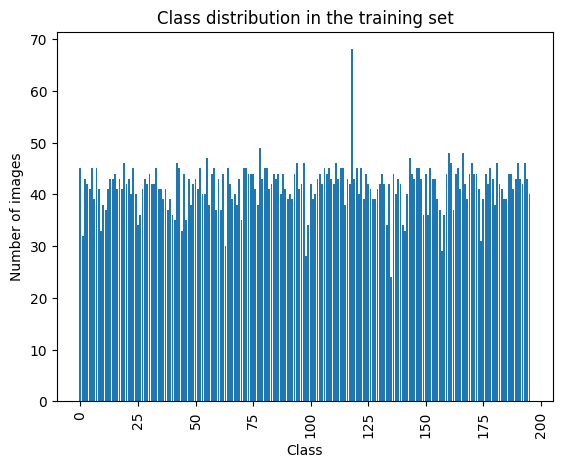


Classi più frequenti nel training set:
GMC Savana Van 2012: 68 images
Chrysler 300 SRT-8 2010: 49 images
Mitsubishi Lancer Sedan 2012: 48 images
Mercedes-Benz 300-Class Convertible 1993: 48 images
Jaguar XK XKR 2012: 47 images

Classi meno nel training set frequenti:
Rolls-Royce Phantom Drophead Coupe Convertible 2012: 31 images
Chevrolet Express Cargo Van 2007: 30 images
Maybach Landaulet Convertible 2012: 29 images
FIAT 500 Abarth 2012: 28 images
Hyundai Accent Sedan 2012: 24 images


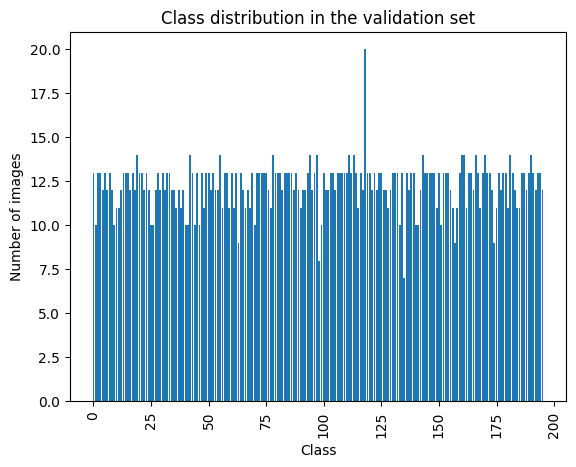


Classi più frequenti nel validation set:
GMC Savana Van 2012: 20 images
Nissan 240SX Coupe 1998: 14 images
Mercedes-Benz C-Class Sedan 2012: 14 images
Chrysler 300 SRT-8 2010: 14 images
Ford F-150 Regular Cab 2007: 14 images

Classi meno nel training validation frequenti:
Rolls-Royce Phantom Drophead Coupe Convertible 2012: 9 images
Maybach Landaulet Convertible 2012: 9 images
Chevrolet Express Cargo Van 2007: 9 images
FIAT 500 Abarth 2012: 8 images
Hyundai Accent Sedan 2012: 7 images


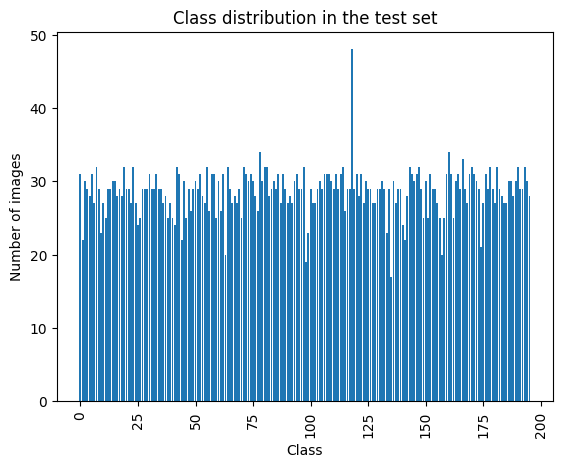


Classi più frequenti nel test set:
GMC Savana Van 2012: 48 images
Mercedes-Benz 300-Class Convertible 1993: 34 images
Chrysler 300 SRT-8 2010: 34 images
Mitsubishi Lancer Sedan 2012: 33 images
Ford Focus Sedan 2007: 32 images

Classi meno frequenti nel test set:
Rolls-Royce Phantom Drophead Coupe Convertible 2012: 21 images
Maybach Landaulet Convertible 2012: 20 images
Chevrolet Express Cargo Van 2007: 20 images
FIAT 500 Abarth 2012: 19 images
Hyundai Accent Sedan 2012: 17 images


In [6]:
import matplotlib.pyplot as plt
from collections import Counter

labels_test = labels[test_indices]
labels_val = labels[val_indices]

######## TRAINING ##############

# Conta quante immagini per ogni classe
class_counts = Counter(labels_training)
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution in the training set")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

# Ordina per frequenza
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualizza le classi più frequenti e meno frequenti
num_top_classes = 5  # Quante classi più frequenti e meno frequenti vuoi vedere?

most_common = sorted_classes[:num_top_classes]
least_common = sorted_classes[-num_top_classes:]

print("\nClassi più frequenti nel training set:")
for idx, count in most_common:
    print(f"{class_names[idx]}: {count} images")

print("\nClassi meno nel training set frequenti:")
for idx, count in least_common:
    print(f"{class_names[idx]}: {count} images")


######## VALIDATION ##############

# Conta quante immagini per ogni classe
class_counts = Counter(labels_val)
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution in the validation set")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

# Ordina per frequenza
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualizza le classi più frequenti e meno frequenti
num_top_classes = 5  # Quante classi più frequenti e meno frequenti vuoi vedere?

most_common = sorted_classes[:num_top_classes]
least_common = sorted_classes[-num_top_classes:]

print("\nClassi più frequenti nel validation set:")
for idx, count in most_common:
    print(f"{class_names[idx]}: {count} images")

print("\nClassi meno nel training validation frequenti:")
for idx, count in least_common:
    print(f"{class_names[idx]}: {count} images")

######## TEST ##############

# Conta quante immagini per ogni classe
class_counts = Counter(labels_test)
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution in the test set")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

# Ordina per frequenza
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Visualizza le classi più frequenti e meno frequenti
num_top_classes = 5  # Quante classi più frequenti e meno frequenti vuoi vedere?

most_common = sorted_classes[:num_top_classes]
least_common = sorted_classes[-num_top_classes:]

print("\nClassi più frequenti nel test set:")
for idx, count in most_common:
    print(f"{class_names[idx]}: {count} images")

print("\nClassi meno frequenti nel test set:")
for idx, count in least_common:
    print(f"{class_names[idx]}: {count} images")



## Visualizzazione di ogni classe presente nel dataset

### Confronto per ogni classe della versione originale e della versione augmented.

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Carica il dataset senza applicare augmentation
full_trainset_no_augmentation = torchvision.datasets.StanfordCars(root=dataset_path, split='train', download=False, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))


# Carica il dataset con le trasformazioni di augmentation
full_trainset_with_augmentation = torchvision.datasets.StanfordCars(root=dataset_path, split='train', download=False, transform=data_transforms['train'])


# Funzione per denormalizzare le immagini (usata per la visualizzazione)
def denorm(x):
    out = x * 0.229 + 0.485  # Denormalizza con i valori di mean e std di ImageNet
    return out.clamp(0, 1)


to_pil = transforms.ToPILImage()



In [ ]:
############## 70 30 #################
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Carica il dataset senza applicare augmentation
full_trainset_no_augmentation = Subset(CustomStanfordCars(all_paths, labels, transform=data_transforms['test']), train_indices)

# Carica il dataset con le trasformazioni di augmentation
full_trainset_with_augmentation = Subset(CustomStanfordCars(all_paths, labels, transform=data_transforms['train']), train_indices)


# Funzione per denormalizzare le immagini (usata per la visualizzazione)
def denorm(x):
    out = x * 0.229 + 0.485  # Denormalizza con i valori di mean e std di ImageNet
    return out.clamp(0, 1)


to_pil = transforms.ToPILImage()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Dizionari per raccogliere un'immagine per classe
unique_classes_no_aug = {}
unique_classes_with_aug = {}

# Scorriamo il dataset originale per raccogliere un esempio per classe
for img, label in full_trainset_no_augmentation:
    if label not in unique_classes_no_aug:
        unique_classes_no_aug[label] = img
    if len(unique_classes_no_aug) == len(class_names):  # Fermiamo quando abbiamo tutte le classi
        break

# Scorriamo il dataset con augmentation per raccogliere un esempio per classe
for img, label in full_trainset_with_augmentation:
    if label not in unique_classes_with_aug:
        unique_classes_with_aug[label] = img
    if len(unique_classes_with_aug) == len(class_names):  # Fermiamo quando abbiamo tutte le classi
        break

# Ordiniamo per classe
sorted_classes = sorted(unique_classes_no_aug.items())

# Creiamo il plot con due colonne: originale a sinistra, aumentata a destra
fig, axes = plt.subplots(nrows=len(sorted_classes), ncols=2, figsize=(8, len(sorted_classes) * 2))

for i, (label, img_no_aug) in enumerate(sorted_classes):
    img_aug = unique_classes_with_aug[label]  # Corrispondente immagine aumentata

    # Immagine originale
    axes[i, 0].imshow(to_pil(denorm(img_no_aug)))
    axes[i, 0].set_title(f"Originale - {class_names[label]}", fontsize=7)
    axes[i, 0].axis("off")

    # Immagine aumentata
    axes[i, 1].imshow(to_pil(denorm(img_aug)))
    axes[i, 1].set_title(f"Augmented - {class_names[label]}", fontsize=7)
    axes[i, 1].axis("off")

plt.tight_layout()  # Ottimizza lo spazio
plt.show()

Output hidden; open in https://colab.research.google.com to view.

###Visualizzazione di una foto per ciascuna classe

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


# Ordiniamo per classe
sorted_classes = sorted(unique_classes_no_aug.items())

# Mostriamo le immagini con le etichette
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 30))  # Grid 14x14 (196 classi)
axes = axes.flatten()  # Flatten per iterare facilmente

for i, (label, img_no_aug) in enumerate(sorted_classes):
    # Immagine originale
    axes[i].imshow(to_pil(denorm(img_no_aug)))
    axes[i].set_title(f"{class_names[label]}", fontsize=10)
    axes[i].axis("off")  # Rimuoviamo gli assi per pulizia

plt.tight_layout()  # Ottimizza la spaziatura
plt.show()


Output hidden; open in https://colab.research.google.com to view.